# SVM vs QSVM

In [2]:
!pip install qiskit==0.42.1 qiskit-machine-learning==0.6.0 qiskit-aer==0.12.0

## Preparación de los datos

In [3]:
import pandas as pd

data = pd.read_csv("data.csv")

data.head()

,category,amt,state,lat,long,is_fraud,hora,dia,mes,edad,card_type,previous_fraud_client,previous_fraud_merchant,gender_M,periodo_dia_noche,periodo_dia_tarde
0,0.002404,91.82,0.005391,41.6060,-109.2300,0,12,5,8,36,0.005559,1.0,1.0,False,False,False
1,0.001621,38.60,0.005991,37.0581,-86.1938,0,12,5,8,21,0.005652,1.0,1.0,False,False,False
2,0.013720,104.39,0.006025,44.8232,-89.1665,0,7,5,8,66,0.005652,1.0,1.0,True,False,False
3,0.013989,3.68,0.005193,46.5901,-117.1692,0,10,5,8,77,0.005652,1.0,1.0,False,False,False
4,0.013989,1.61,0.006197,42.1939,-76.7361,0,8,5,8,29,0.004766,1.0,1.0,False,False,False


In [4]:
data_2 = data.drop(['state', 'lat', 'long', 'hora', 'dia', 'mes', 'gender_M', 'periodo_dia_tarde'], axis=1)

data_2.columns

Index(['category', 'amt', 'is_fraud', 'edad', 'card_type',
       'previous_fraud_client', 'previous_fraud_merchant',
       'periodo_dia_noche'],
      dtype='object')

## Estudio Comparativo (Desbalanceo 75-25)

In [25]:
import pandas as pd

def crear_submuestra_balanceada(df, label_col, total_muestra, proporcion_clase_mayor=0.75):
    # Contar clases
    clases = df['is_fraud'].unique()
    if len(clases) != 2:
        raise ValueError("Este método está pensado para problemas binarios (dos clases).")

    # Determinar cuántas instancias tomar de cada clase
    n_mayor = int(total_muestra * proporcion_clase_mayor)
    n_menor = total_muestra - n_mayor

    # Detectar qué clase es la mayor
    conteos = df['is_fraud'].value_counts()
    clase_mayor = conteos.idxmax()
    clase_menor = conteos.idxmin()

    # Tomar muestras aleatorias
    df_mayor = df[df['is_fraud'] == clase_mayor].sample(n=n_mayor, random_state=42)
    df_menor = df[df['is_fraud'] == clase_menor].sample(n=n_menor, random_state=42)

    # Combinar y mezclar
    df_final = pd.concat([df_mayor, df_menor]).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_final

# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500)
df3 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=1000)

### 200 datos

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### SVM

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Creamos y entrenamos en módelo SVC clásico.
svm_200 = SVC(kernel='rbf', probability=True)
svm_200.fit(x_train_1, y_train_1)

SVC(probability=True)

In [8]:
# Se evalúan los resultados.
y_pred_svm_200 = svm_200.predict(x_test_1)

accuracy_svm_200 = accuracy_score(y_test_1, y_pred_svm_200)
print("Accuracy:", accuracy_svm_200)
prec_svm_200 = precision_score(y_test_1, y_pred_svm_200)
print("Precision:", prec_svm_200)
rec_svm_200 = recall_score(y_test_1, y_pred_svm_200)
print("Recall:", rec_svm_200)
f1_svm_200 = f1_score(y_test_1, y_pred_svm_200)
print("F1 Score:", f1_svm_200)
print(classification_report(y_test_1, y_pred_svm_200))

Accuracy: 0.9166666666666666
Precision: 1.0
Recall: 0.6666666666666666
F1 Score: 0.8
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        45
         1.0       1.00      0.67      0.80        15

    accuracy                           0.92        60
   macro avg       0.95      0.83      0.87        60
weighted avg       0.93      0.92      0.91        60



Tiempo de entrenamiento/inferencia: Inmediato

#### QSVM

In [9]:
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_aer import Aer
import numpy as np

# Codificamos los datos en el circuito cuántico.
feature_map = ZZFeatureMap(x_train_1.shape[1], reps=2)

# Instanciamos el simulador de backend.
quantum_instance = Aer.get_backend('aer_simulator_statevector')

# Creamos el kernel cuántico.
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

# Creamos y entrenamos el clasificador cuántico.
qsvm_200 = QSVC(quantum_kernel=quantum_kernel, class_weight='balanced', C=0.1, gamma=1)
qsvm_200.fit(x_train_1, y_train_1)

QSVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced',
     coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1, max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7a6cc802dfd0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [10]:
# Evaluamos el modelo obtenido.
y_pred_qsvm_200 = qsvm_200.predict(x_test_1)

accuracy_qsvm_200 = accuracy_score(y_test_1, y_pred_qsvm_200)
print("Accuracy:", accuracy_qsvm_200)
prec_qsvm_200 = precision_score(y_test_1, y_pred_qsvm_200)
print("Precision:", prec_qsvm_200)
rec_qsvm_200 = recall_score(y_test_1, y_pred_qsvm_200)
print("Recall:", rec_qsvm_200)
f1_qsvm_200 = f1_score(y_test_1, y_pred_qsvm_200)
print("F1 Score:", f1_qsvm_200)
print(classification_report(y_test_1, y_pred_qsvm_200))

Accuracy: 0.8
Precision: 1.0
Recall: 0.2
F1 Score: 0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88        45
         1.0       1.00      0.20      0.33        15

    accuracy                           0.80        60
   macro avg       0.89      0.60      0.61        60
weighted avg       0.84      0.80      0.75        60



### 500 datos

In [11]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### SVM

In [12]:
# Creamos y entrenamos en módelo SVC clásico.
svm_500 = SVC(kernel='rbf', probability=True)
svm_500.fit(x_train_1, y_train_1)

# Se evalúan los resultados.
y_pred_svm_500 = svm_500.predict(x_test_1)

accuracy_svm_500 = accuracy_score(y_test_1, y_pred_svm_500)
print("Accuracy:", accuracy_svm_500)
prec_svm_500 = precision_score(y_test_1, y_pred_svm_500)
print("Precision:", prec_svm_500)
rec_svm_500 = recall_score(y_test_1, y_pred_svm_500)
print("Recall:", rec_svm_500)
f1_svm_500 = f1_score(y_test_1, y_pred_svm_500)
print("F1 Score:", f1_svm_500)
print(classification_report(y_test_1, y_pred_svm_500))

Accuracy: 0.9266666666666666
Precision: 0.9333333333333333
Recall: 0.7567567567567568
F1 Score: 0.835820895522388
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       113
         1.0       0.93      0.76      0.84        37

    accuracy                           0.93       150
   macro avg       0.93      0.87      0.89       150
weighted avg       0.93      0.93      0.92       150



#### QSVM

In [13]:
# Codificamos los datos en el circuito cuántico.
feature_map = ZZFeatureMap(x_train_1.shape[1], reps=2)

# Instanciamos el simulador de backend.
quantum_instance = Aer.get_backend('aer_simulator_statevector')

# Creamos el kernel cuántico.
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

# Creamos y entrenamos el clasificador cuántico.
qsvm_500 = QSVC(quantum_kernel=quantum_kernel, class_weight='balanced', C=0.1, gamma=1)
qsvm_500.fit(x_train_1, y_train_1)

# Evaluamos el modelo obtenido.
y_pred_qsvm_500 = qsvm_500.predict(x_test_1)

accuracy_qsvm_500 = accuracy_score(y_test_1, y_pred_qsvm_500)
print("Accuracy:", accuracy_qsvm_500)
prec_qsvm_500 = precision_score(y_test_1, y_pred_qsvm_500)
print("Precision:", prec_qsvm_500)
rec_qsvm_500 = recall_score(y_test_1, y_pred_qsvm_500)
print("Recall:", rec_qsvm_500)
f1_qsvm_500 = f1_score(y_test_1, y_pred_qsvm_500)
print("F1 Score:", f1_qsvm_500)
print(classification_report(y_test_1, y_pred_qsvm_500))

Accuracy: 0.7533333333333333
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86       113
         1.0       0.00      0.00      0.00        37

    accuracy                           0.75       150
   macro avg       0.38      0.50      0.43       150
weighted avg       0.57      0.75      0.65       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### 1000 datos

In [26]:
x1 = df3.drop(columns='is_fraud')
y1 = df3['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### SVM

In [27]:
# Creamos y entrenamos en módelo SVC clásico.
svm_1000 = SVC(kernel='rbf', probability=True)
svm_1000.fit(x_train_1, y_train_1)

# Se evalúan los resultados.
y_pred_svm_1000 = svm_1000.predict(x_test_1)

accuracy_svm_1000 = accuracy_score(y_test_1, y_pred_svm_1000)
print("Accuracy:", accuracy_svm_1000)
prec_svm_1000 = precision_score(y_test_1, y_pred_svm_1000)
print("Precision:", prec_svm_1000)
rec_svm_1000 = recall_score(y_test_1, y_pred_svm_1000)
print("Recall:", rec_svm_1000)
f1_svm_1000 = f1_score(y_test_1, y_pred_svm_1000)
print("F1 Score:", f1_svm_1000)
print(classification_report(y_test_1, y_pred_svm_1000))

Accuracy: 0.93
Precision: 0.921875
Recall: 0.7866666666666666
F1 Score: 0.8489208633093526
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       225
         1.0       0.92      0.79      0.85        75

    accuracy                           0.93       300
   macro avg       0.93      0.88      0.90       300
weighted avg       0.93      0.93      0.93       300



#### QSVM

In [28]:
# Codificamos los datos en el circuito cuántico.
feature_map = ZZFeatureMap(x_train_1.shape[1], reps=2)

# Instanciamos el simulador de backend.
quantum_instance = Aer.get_backend('aer_simulator_statevector')

# Creamos el kernel cuántico.
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

# Creamos y entrenamos el clasificador cuántico.
qsvm_1000 = QSVC(quantum_kernel=quantum_kernel, class_weight='balanced', C=0.1, gamma=1)
qsvm_1000.fit(x_train_1, y_train_1)

# Evaluamos el modelo obtenido.
y_pred_qsvm_1000 = qsvm_1000.predict(x_test_1)

accuracy_qsvm_1000 = accuracy_score(y_test_1, y_pred_qsvm_1000)
print("Accuracy:", accuracy_qsvm_1000)
prec_qsvm_1000 = precision_score(y_test_1, y_pred_qsvm_1000)
print("Precision:", prec_qsvm_1000)
rec_qsvm_1000 = recall_score(y_test_1, y_pred_qsvm_1000)
print("Recall:", rec_qsvm_1000)
f1_qsvm_1000 = f1_score(y_test_1, y_pred_qsvm_1000)
print("F1 Score:", f1_qsvm_1000)
print(classification_report(y_test_1, y_pred_qsvm_1000))

Accuracy: 0.7733333333333333
Precision: 0.5294117647058824
Recall: 0.84
F1 Score: 0.6494845360824743
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83       225
         1.0       0.53      0.84      0.65        75

    accuracy                           0.77       300
   macro avg       0.73      0.80      0.74       300
weighted avg       0.83      0.77      0.79       300



## Estudio Comparativo (Sin Desbalanceo)

In [29]:
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200, proporcion_clase_mayor=0.5)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500, proporcion_clase_mayor=0.5)
df3 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=1000, proporcion_clase_mayor=0.5)

### 200 datos

In [15]:
x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### SVM

In [16]:
# Creamos y entrenamos en módelo SVC clásico.
svm_200_2 = SVC(kernel='rbf', probability=True)
svm_200_2.fit(x_train_1, y_train_1)

# Se evalúan los resultados.
y_pred_svm_200_2 = svm_200_2.predict(x_test_1)

accuracy_svm_200_2 = accuracy_score(y_test_1, y_pred_svm_200_2)
print("Accuracy:", accuracy_svm_200_2)
prec_svm_200_2 = precision_score(y_test_1, y_pred_svm_200_2)
print("Precision:", prec_svm_200_2)
rec_svm_200_2 = recall_score(y_test_1, y_pred_svm_200_2)
print("Recall:", rec_svm_200_2)
f1_svm_200_2 = f1_score(y_test_1, y_pred_svm_200_2)
print("F1 Score:", f1_svm_200_2)
print(classification_report(y_test_1, y_pred_svm_200_2))

Accuracy: 0.8333333333333334
Precision: 0.9166666666666666
Recall: 0.7333333333333333
F1 Score: 0.8148148148148148
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85        30
         1.0       0.92      0.73      0.81        30

    accuracy                           0.83        60
   macro avg       0.85      0.83      0.83        60
weighted avg       0.85      0.83      0.83        60



#### QSVM

In [17]:
# Codificamos los datos en el circuito cuántico.
feature_map = ZZFeatureMap(x_train_1.shape[1], reps=2)

# Instanciamos el simulador de backend.
quantum_instance = Aer.get_backend('aer_simulator_statevector')

# Creamos el kernel cuántico.
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

# Creamos y entrenamos el clasificador cuántico.
qsvm_200_2 = QSVC(quantum_kernel=quantum_kernel, class_weight='balanced', C=0.1, gamma=1)
qsvm_200_2.fit(x_train_1, y_train_1)

# Evaluamos el modelo obtenido.
y_pred_qsvm_200_2 = qsvm_200_2.predict(x_test_1)

accuracy_qsvm_200_2 = accuracy_score(y_test_1, y_pred_qsvm_200_2)
print("Accuracy:", accuracy_qsvm_200_2)
prec_qsvm_200_2 = precision_score(y_test_1, y_pred_qsvm_200_2)
print("Precision:", prec_qsvm_200_2)
rec_qsvm_200_2 = recall_score(y_test_1, y_pred_qsvm_200_2)
print("Recall:", rec_qsvm_200_2)
f1_qsvm_200_2 = f1_score(y_test_1, y_pred_qsvm_200_2)
print("F1 Score:", f1_qsvm_200_2)
print(classification_report(y_test_1, y_pred_qsvm_200_2))

Accuracy: 0.75
Precision: 0.7272727272727273
Recall: 0.8
F1 Score: 0.7619047619047619
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        30
         1.0       0.73      0.80      0.76        30

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60



### 500 datos

In [18]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### SVM

In [19]:
# Creamos y entrenamos en módelo SVC clásico.
svm_500_2 = SVC(kernel='rbf', probability=True)
svm_500_2.fit(x_train_1, y_train_1)

# Se evalúan los resultados.
y_pred_svm_500_2 = svm_500_2.predict(x_test_1)

accuracy_svm_500_2 = accuracy_score(y_test_1, y_pred_svm_500_2)
print("Accuracy:", accuracy_svm_500_2)
prec_svm_500_2 = precision_score(y_test_1, y_pred_svm_500_2)
print("Precision:", prec_svm_500_2)
rec_svm_500_2 = recall_score(y_test_1, y_pred_svm_500_2)
print("Recall:", rec_svm_500_2)
f1_svm_500_2 = f1_score(y_test_1, y_pred_svm_500_2)
print("F1 Score:", f1_svm_500_2)
print(classification_report(y_test_1, y_pred_svm_500_2))

Accuracy: 0.8866666666666667
Precision: 0.9833333333333333
Recall: 0.7866666666666666
F1 Score: 0.8740740740740741
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90        75
         1.0       0.98      0.79      0.87        75

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



#### QSVM

In [20]:
# Codificamos los datos en el circuito cuántico.
feature_map = ZZFeatureMap(x_train_1.shape[1], reps=2)

# Instanciamos el simulador de backend.
quantum_instance = Aer.get_backend('aer_simulator_statevector')

# Creamos el kernel cuántico.
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

# Creamos y entrenamos el clasificador cuántico.
qsvm_500_2 = QSVC(quantum_kernel=quantum_kernel, class_weight='balanced', C=0.1, gamma=1)
qsvm_500_2.fit(x_train_1, y_train_1)

# Evaluamos el modelo obtenido.
y_pred_qsvm_500_2 = qsvm_500_2.predict(x_test_1)

accuracy_qsvm_500_2 = accuracy_score(y_test_1, y_pred_qsvm_500_2)
print("Accuracy:", accuracy_qsvm_500_2)
prec_qsvm_500_2 = precision_score(y_test_1, y_pred_qsvm_500_2)
print("Precision:", prec_qsvm_500_2)
rec_qsvm_500_2 = recall_score(y_test_1, y_pred_qsvm_500_2)
print("Recall:", rec_qsvm_500_2)
f1_qsvm_500_2 = f1_score(y_test_1, y_pred_qsvm_500_2)
print("F1 Score:", f1_qsvm_500_2)
print(classification_report(y_test_1, y_pred_qsvm_500_2))

Accuracy: 0.8066666666666666
Precision: 0.7446808510638298
Recall: 0.9333333333333333
F1 Score: 0.8284023668639053
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78        75
         1.0       0.74      0.93      0.83        75

    accuracy                           0.81       150
   macro avg       0.83      0.81      0.80       150
weighted avg       0.83      0.81      0.80       150



### 1000 datos

In [30]:
x1 = df3.drop(columns='is_fraud')
y1 = df3['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### SVM

In [31]:
# Creamos y entrenamos en módelo SVC clásico.
svm_1000_2 = SVC(kernel='rbf', probability=True)
svm_1000_2.fit(x_train_1, y_train_1)

# Se evalúan los resultados.
y_pred_svm_1000_2 = svm_1000_2.predict(x_test_1)

accuracy_svm_1000_2 = accuracy_score(y_test_1, y_pred_svm_1000_2)
print("Accuracy:", accuracy_svm_1000_2)
prec_svm_1000_2 = precision_score(y_test_1, y_pred_svm_1000_2)
print("Precision:", prec_svm_1000_2)
rec_svm_1000_2 = recall_score(y_test_1, y_pred_svm_1000_2)
print("Recall:", rec_svm_1000_2)
f1_svm_1000_2 = f1_score(y_test_1, y_pred_svm_1000_2)
print("F1 Score:", f1_svm_1000_2)
print(classification_report(y_test_1, y_pred_svm_1000_2))

Accuracy: 0.8766666666666667
Precision: 0.9747899159663865
Recall: 0.7733333333333333
F1 Score: 0.862453531598513
              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89       150
         1.0       0.97      0.77      0.86       150

    accuracy                           0.88       300
   macro avg       0.89      0.88      0.88       300
weighted avg       0.89      0.88      0.88       300



#### QSVM

In [32]:
# Codificamos los datos en el circuito cuántico.
feature_map = ZZFeatureMap(x_train_1.shape[1], reps=2)

# Instanciamos el simulador de backend.
quantum_instance = Aer.get_backend('aer_simulator_statevector')

# Creamos el kernel cuántico.
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

# Creamos y entrenamos el clasificador cuántico.
qsvm_1000_2 = QSVC(quantum_kernel=quantum_kernel, class_weight='balanced', C=0.1, gamma=1)
qsvm_1000_2.fit(x_train_1, y_train_1)

# Evaluamos el modelo obtenido.
y_pred_qsvm_1000_2 = qsvm_1000_2.predict(x_test_1)

accuracy_qsvm_1000_2 = accuracy_score(y_test_1, y_pred_qsvm_1000_2)
print("Accuracy:", accuracy_qsvm_1000_2)
prec_qsvm_1000_2 = precision_score(y_test_1, y_pred_qsvm_1000_2)
print("Precision:", prec_qsvm_1000_2)
rec_qsvm_1000_2 = recall_score(y_test_1, y_pred_qsvm_1000_2)
print("Recall:", rec_qsvm_1000_2)
f1_qsvm_1000_2 = f1_score(y_test_1, y_pred_qsvm_1000_2)
print("F1 Score:", f1_qsvm_1000_2)
print(classification_report(y_test_1, y_pred_qsvm_1000_2))

Accuracy: 0.7566666666666667
Precision: 0.6878048780487804
Recall: 0.94
F1 Score: 0.7943661971830986
              precision    recall  f1-score   support

         0.0       0.91      0.57      0.70       150
         1.0       0.69      0.94      0.79       150

    accuracy                           0.76       300
   macro avg       0.80      0.76      0.75       300
weighted avg       0.80      0.76      0.75       300



## Resultados

### Accuracy

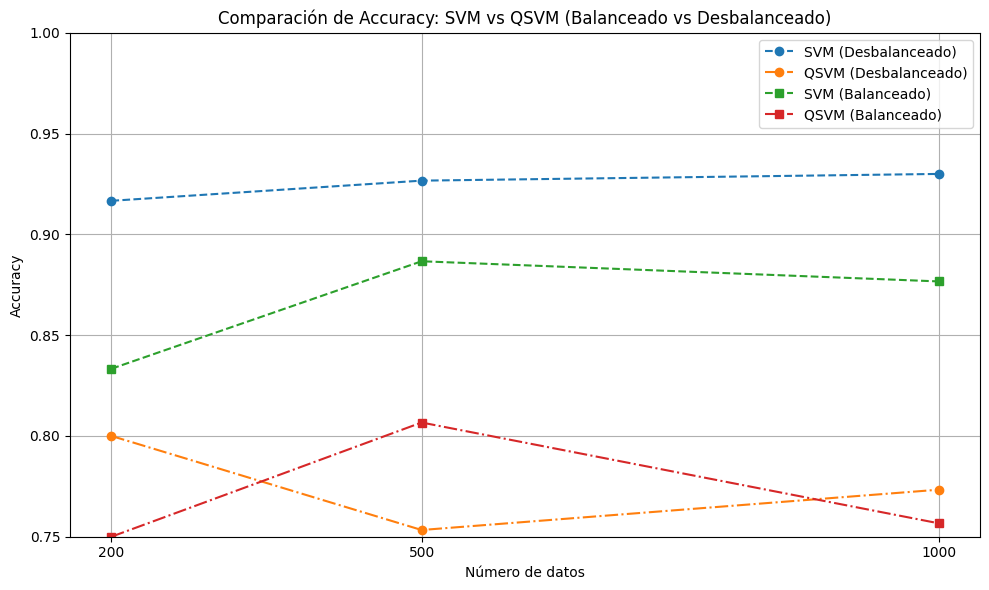

In [33]:
import matplotlib.pyplot as plt

# Eje X: número de datos
num_datos = [200, 500, 1000]

# Desbalanceado
acc_svm_desb = [accuracy_svm_200, accuracy_svm_500, accuracy_svm_1000]
acc_qsvm_desb = [accuracy_qsvm_200, accuracy_qsvm_500, accuracy_qsvm_1000]

# Balanceado
acc_svm_bal = [accuracy_svm_200_2, accuracy_svm_500_2, accuracy_svm_1000_2]
acc_qsvm_bal = [accuracy_qsvm_200_2, accuracy_qsvm_500_2, accuracy_qsvm_1000_2]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_svm_desb, marker='o', linestyle='--', label='SVM (Desbalanceado)')
plt.plot(num_datos, acc_qsvm_desb, marker='o', linestyle='-.', label='QSVM (Desbalanceado)')
plt.plot(num_datos, acc_svm_bal, marker='s', linestyle='--', label='SVM (Balanceado)')
plt.plot(num_datos, acc_qsvm_bal, marker='s', linestyle='-.', label='QSVM (Balanceado)')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: SVM vs QSVM (Balanceado vs Desbalanceado)')
plt.xticks([200, 500, 1000])
plt.ylim(0.75, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score

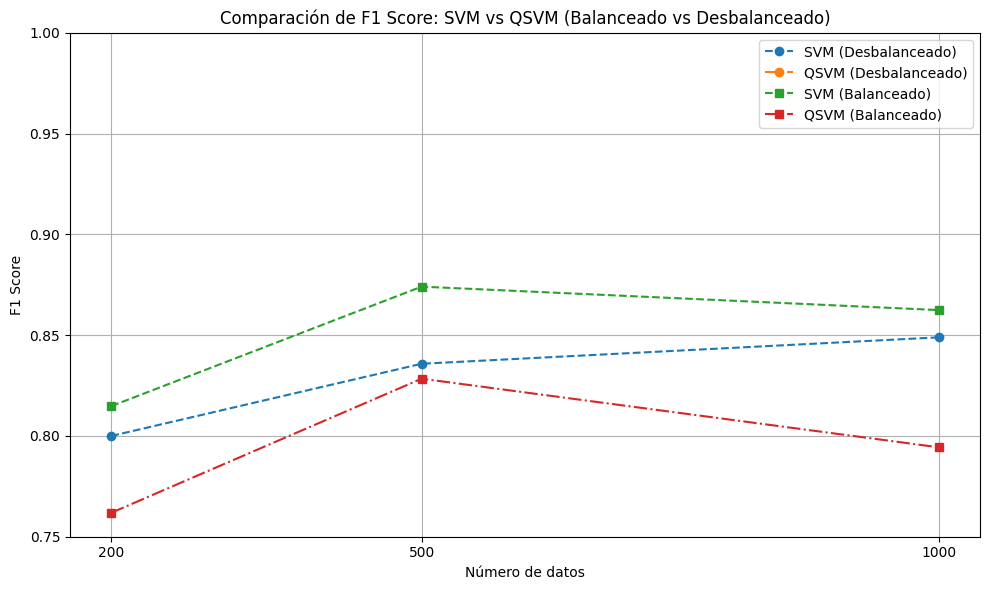

In [34]:
# Eje X: número de datos
num_datos = [200, 500, 1000]

# Desbalanceado
f1_svm_desb = [f1_svm_200, f1_svm_500, f1_svm_1000]
f1_qsvm_desb = [f1_qsvm_200, f1_qsvm_500, f1_qsvm_1000]

# Balanceado
f1_svm_bal = [f1_svm_200_2, f1_svm_500_2, f1_svm_1000_2]
f1_qsvm_bal = [f1_qsvm_200_2, f1_qsvm_500_2, f1_qsvm_1000_2]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_svm_desb, marker='o', linestyle='--', label='SVM (Desbalanceado)')
plt.plot(num_datos, f1_qsvm_desb, marker='o', linestyle='-.', label='QSVM (Desbalanceado)')
plt.plot(num_datos, f1_svm_bal, marker='s', linestyle='--', label='SVM (Balanceado)')
plt.plot(num_datos,f1_qsvm_bal, marker='s', linestyle='-.', label='QSVM (Balanceado)')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: SVM vs QSVM (Balanceado vs Desbalanceado)')
plt.xticks([200, 500, 1000])
plt.ylim(0.75, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NOTA: QSVM Desbalanceado no sale porque su puntuación es notablemente inferior a la de los demás, está por debajo del valor de 0.75 que se toma como límite en el eje Y.